In [1]:
import numpy as np
import tensorflow as tf

from vae import VariationalAutoEncoder

tf.logging.set_verbosity(tf.logging.INFO)


class ConvolutionalVariationalAutoEncoder(VariationalAutoEncoder):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        super().__init__(network_architecture, learning_rate=learning_rate, batch_size=batch_size)

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_layers = [None for i in range(self.n_layers + 1)]
        self.output_layers = [None for i in range(self.n_layers + 1)]

    def _recognition_network(self):
        self.input_layers[0] = tf.reshape(self.x, [-1, self.image_width, self.image_width, 1])
        self.ft_size = self.image_width // 2
        self.conv_size = self.image_width
        for i in range(1, self.n_layers + 1):
            self.conv_size //= 2
            self.ft_size *= 2
            self.input_layers[i] = tf.layers.conv2d(
                inputs=self.input_layers[i - 1],
                kernel_size=4,
                strides=2,
                filters=self.ft_size,
                padding="same",
                activation=tf.nn.relu,
            )
        self.z_mean = tf.layers.dense(
            inputs=tf.layers.flatten(self.input_layers[-1]),
            units=self.n_z,
            name="z_mean",
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=tf.layers.flatten(self.input_layers[-1]),
            units=self.n_z,
            name="z_log_sigma_sq",
        )

    def _generator_network(self):
        self.output_layers[0] = tf.reshape(tf.layers.dense(
            inputs=self.z,
            units=self.conv_size ** 2 * self.ft_size),
            (-1, self.conv_size, self.conv_size, self.ft_size))

        for i in range(1, self.n_layers + 1):
            self.ft_size //= 2
            self.output_layers[i] = tf.layers.conv2d_transpose(
                inputs=self.output_layers[i - 1],
                kernel_size=4,
                strides=2,
                filters=self.ft_size,
                padding="same",
                activation=tf.nn.relu,
            )
        self.x_reconstr_mean = tf.layers.flatten(tf.layers.conv2d(
            inputs=self.output_layers[-1],
            kernel_size=4,
            strides=1,
            filters=1,
            padding="same",
            activation=tf.nn.sigmoid,
        ))

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3,
}

vae = ConvolutionalVariationalAutoEncoder(network_architecture, 0.001, 100)
vae.load("tmp/ConvolutionalVariationalAutoEncoder.20180611235148068561.step260")

INFO:tensorflow:Restoring parameters from tmp/ConvolutionalVariationalAutoEncoder.20180611235148068561.step260


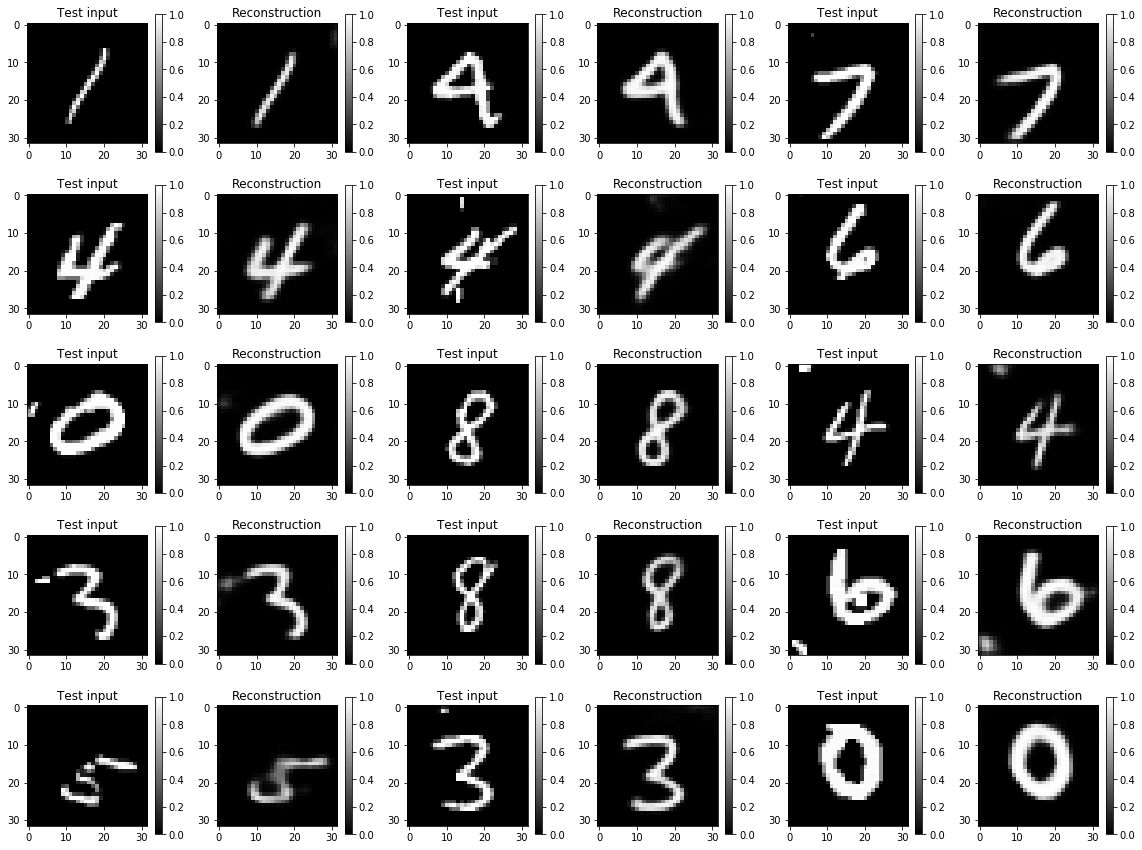

In [3]:
import matplotlib.pyplot as plt
import mnist

n_width = 32
test_x = mnist.test_32()[:100] / 256
x_reconstruct = vae.reconstruct(test_x.reshape((-1, n_width ** 2)))

plt.figure(figsize=(16, 12))
for i in range(15):
    plt.subplot(5, 6, 2 * i + 1)
    plt.imshow(test_x[i].reshape(n_width, n_width), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 6, 2 * i + 2)
    plt.imshow(x_reconstruct[i].reshape(n_width, n_width), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [6]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import mnist

train_x, train_y = mnist.train_32_flat_labeled(10000)
test_x, test_y = mnist.test_32_flat_labeled(300)
train_z = vae.transform(train_x)

clf = svm.SVC()
clf.fit(train_z, train_y)
print(clf.score(vae.transform(test_x), test_y))

0.9233333333333333


In [2]:
from vae import train, VariationalAutoEncoder
from vae_cnn import ConvolutionalVariationalAutoEncoder

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3
}

# vae = train(ConvolutionalVariationalAutoEncoder, network_architecture, training_epochs=300)
vae = train(VariationalAutoEncoder, network_architecture, training_epochs=31)


Epoch: 0001 Cost: 241.124908574 Time: 7.674
Model has been saved to: tmp/VariationalAutoEncoder.20180612141149332583.step0
Epoch: 0002 Cost: 205.406471786 Time: 15.410
Epoch: 0003 Cost: 186.647463888 Time: 22.971
Epoch: 0004 Cost: 176.940697021 Time: 30.535
Epoch: 0005 Cost: 170.582503484 Time: 38.115
Epoch: 0006 Cost: 165.596657740 Time: 45.666
Epoch: 0007 Cost: 161.891081467 Time: 53.286
Epoch: 0008 Cost: 159.576254527 Time: 60.820
Epoch: 0009 Cost: 157.932461268 Time: 68.376
Epoch: 0010 Cost: 156.451798248 Time: 75.937
Epoch: 0011 Cost: 154.884518611 Time: 83.527
Model has been saved to: tmp/VariationalAutoEncoder.20180612141149332583.step10
Epoch: 0012 Cost: 153.500997416 Time: 91.147
Epoch: 0013 Cost: 152.123722941 Time: 98.686
Epoch: 0014 Cost: 151.006747157 Time: 106.241
Epoch: 0015 Cost: 150.140546341 Time: 113.798
Epoch: 0016 Cost: 149.352249349 Time: 121.415
Epoch: 0017 Cost: 148.667698822 Time: 128.994
Epoch: 0018 Cost: 148.115812174 Time: 136.532
Epoch: 0019 Cost: 147.58197

In [1]:
from vae import train, VariationalAutoEncoder
from vae_cnn import ConvolutionalVariationalAutoEncoder

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3
}

# vae = train(ConvolutionalVariationalAutoEncoder, network_architecture, training_epochs=300)
vae = train(VariationalAutoEncoder, network_architecture, training_epochs=50)

Epoch: 0001 Cost: 241.458896179 Time: 7.647
Model has been saved to: tmp/VariationalAutoEncoder.20180612144650176555.step0
Epoch: 0002 Cost: 214.221797587 Time: 15.327
Epoch: 0003 Cost: 190.128293457 Time: 22.923
Epoch: 0004 Cost: 177.906151479 Time: 30.513
Epoch: 0005 Cost: 170.692534968 Time: 38.121
Epoch: 0006 Cost: 167.085805384 Time: 45.726
Epoch: 0007 Cost: 164.130920842 Time: 53.328
Epoch: 0008 Cost: 161.227797445 Time: 60.924
Epoch: 0009 Cost: 158.746695099 Time: 68.544
Epoch: 0010 Cost: 156.992651291 Time: 76.122
Epoch: 0011 Cost: 155.684427007 Time: 83.716
Model has been saved to: tmp/VariationalAutoEncoder.20180612144650176555.step10
Epoch: 0012 Cost: 154.524110565 Time: 91.448
Epoch: 0013 Cost: 153.573204320 Time: 99.017
Epoch: 0014 Cost: 152.768522161 Time: 106.625
Epoch: 0015 Cost: 152.000002187 Time: 114.206
Epoch: 0016 Cost: 151.098241628 Time: 121.841
Epoch: 0017 Cost: 150.168802617 Time: 129.411
Epoch: 0018 Cost: 149.349361318 Time: 136.977
Epoch: 0019 Cost: 148.45855

In [1]:
from vae import train, VariationalAutoEncoder
from vae_cnn import ConvolutionalVariationalAutoEncoder

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 2
}

# vae = train(ConvolutionalVariationalAutoEncoder, network_architecture, training_epochs=300)
vae = train(VariationalAutoEncoder, network_architecture, training_epochs=31)


Epoch: 0001 Cost: 50.327032496 Time: 7.693
Model has been saved to: tmp/VariationalAutoEncoder.20180612145324070812.step0
Epoch: 0002 Cost: 22.723045518 Time: 15.372
Epoch: 0003 Cost: 1.255215124 Time: 22.926
Epoch: 0004 Cost: -10.888524236 Time: 30.520
Epoch: 0005 Cost: -19.117812648 Time: 38.122


KeyboardInterrupt: 

In [1]:
from vae import train, VariationalAutoEncoder
from vae_cnn import ConvolutionalVariationalAutoEncoder

network_architecture = {
    "n_width": 32,
    "n_z": 2,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3
}

# vae = train(ConvolutionalVariationalAutoEncoder, network_architecture, training_epochs=300)
vae = train(VariationalAutoEncoder, network_architecture, training_epochs=50)

Epoch: 0001 Cost: 243.152817459 Time: 7.575
Model has been saved to: tmp/VariationalAutoEncoder.20180612150404337640.step0
Epoch: 0002 Cost: 224.570822067 Time: 15.094
Epoch: 0003 Cost: 211.190618184 Time: 22.457
Epoch: 0004 Cost: 206.425765940 Time: 29.838
Epoch: 0005 Cost: 203.624374364 Time: 37.239
Epoch: 0006 Cost: 201.323383687 Time: 44.604
Epoch: 0007 Cost: 199.501722946 Time: 51.993
Epoch: 0008 Cost: 198.066343842 Time: 59.383
Epoch: 0009 Cost: 196.842925084 Time: 66.698
Epoch: 0010 Cost: 195.676425578 Time: 74.108
Epoch: 0011 Cost: 194.720928472 Time: 81.525
Model has been saved to: tmp/VariationalAutoEncoder.20180612150404337640.step10
Epoch: 0012 Cost: 194.124179789 Time: 89.034
Epoch: 0013 Cost: 193.593893280 Time: 96.488
Epoch: 0014 Cost: 193.035435588 Time: 103.904
Epoch: 0015 Cost: 192.301456680 Time: 111.310
Epoch: 0016 Cost: 191.851738408 Time: 118.770
Epoch: 0017 Cost: 191.435149816 Time: 126.184
Epoch: 0018 Cost: 191.319839630 Time: 133.543
Epoch: 0019 Cost: 190.64499

<Figure size 432x288 with 0 Axes>

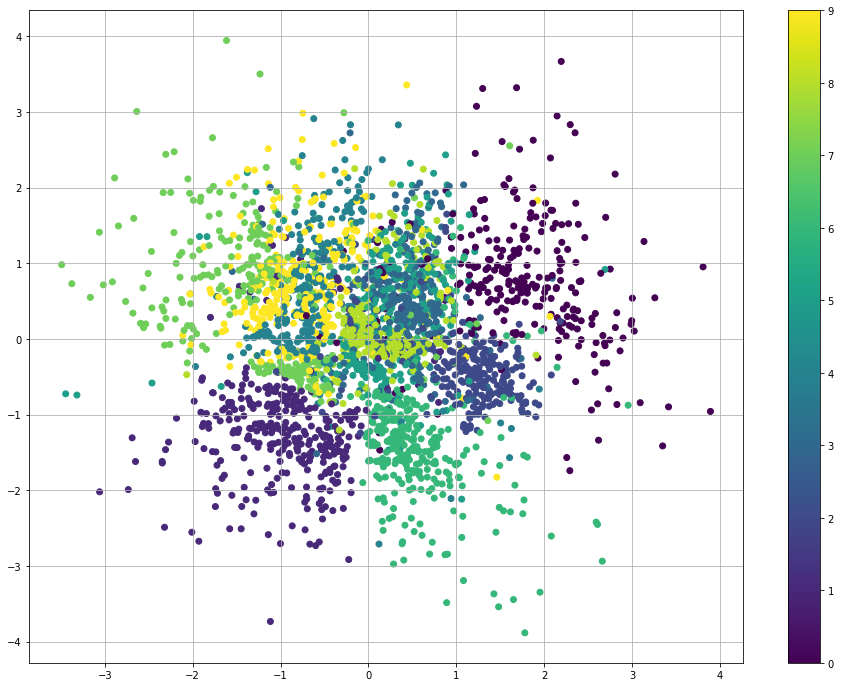

In [8]:
import mnist
import matplotlib.pyplot as plt

x_sample, y_sample = mnist.test_32_flat_labeled(3000)
z_mu = vae.transform(x_sample)

plt.clf()
plt.figure(figsize=(16, 12))
# print(z_mu[:,0], z_mu[:,1])
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample)
plt.colorbar()
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

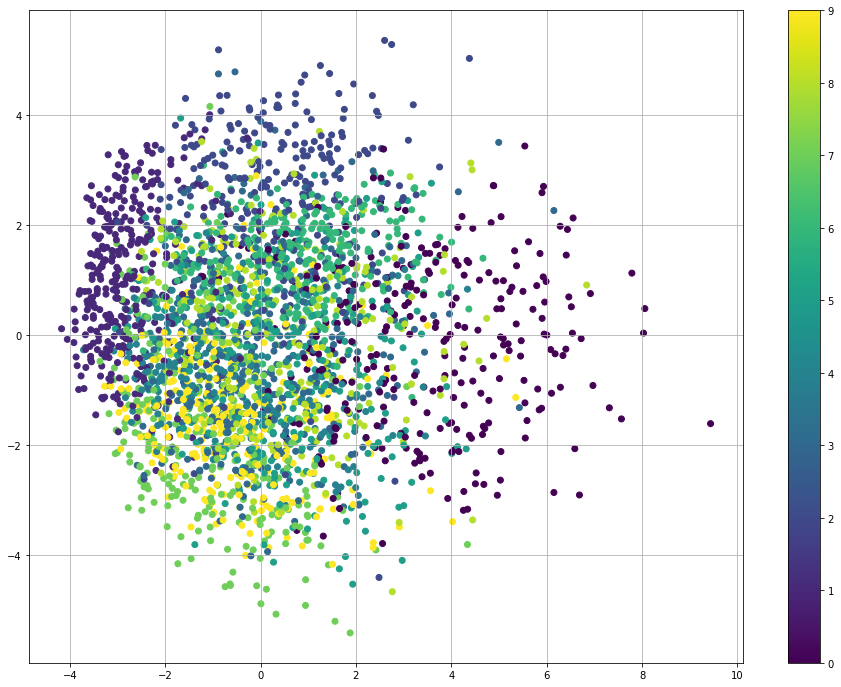

In [10]:
from sklearn.decomposition import PCA
train_x, train_y = mnist.train_32_flat_labeled()
pca = PCA(n_components=2)
pca.fit(train_x, train_y)

z = pca.transform(x_sample)

plt.clf()
plt.figure(figsize=(16, 12))
# print(z_mu[:,0], z_mu[:,1])
plt.scatter(z[:, 0], z[:, 1], c=y_sample)
plt.colorbar()
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

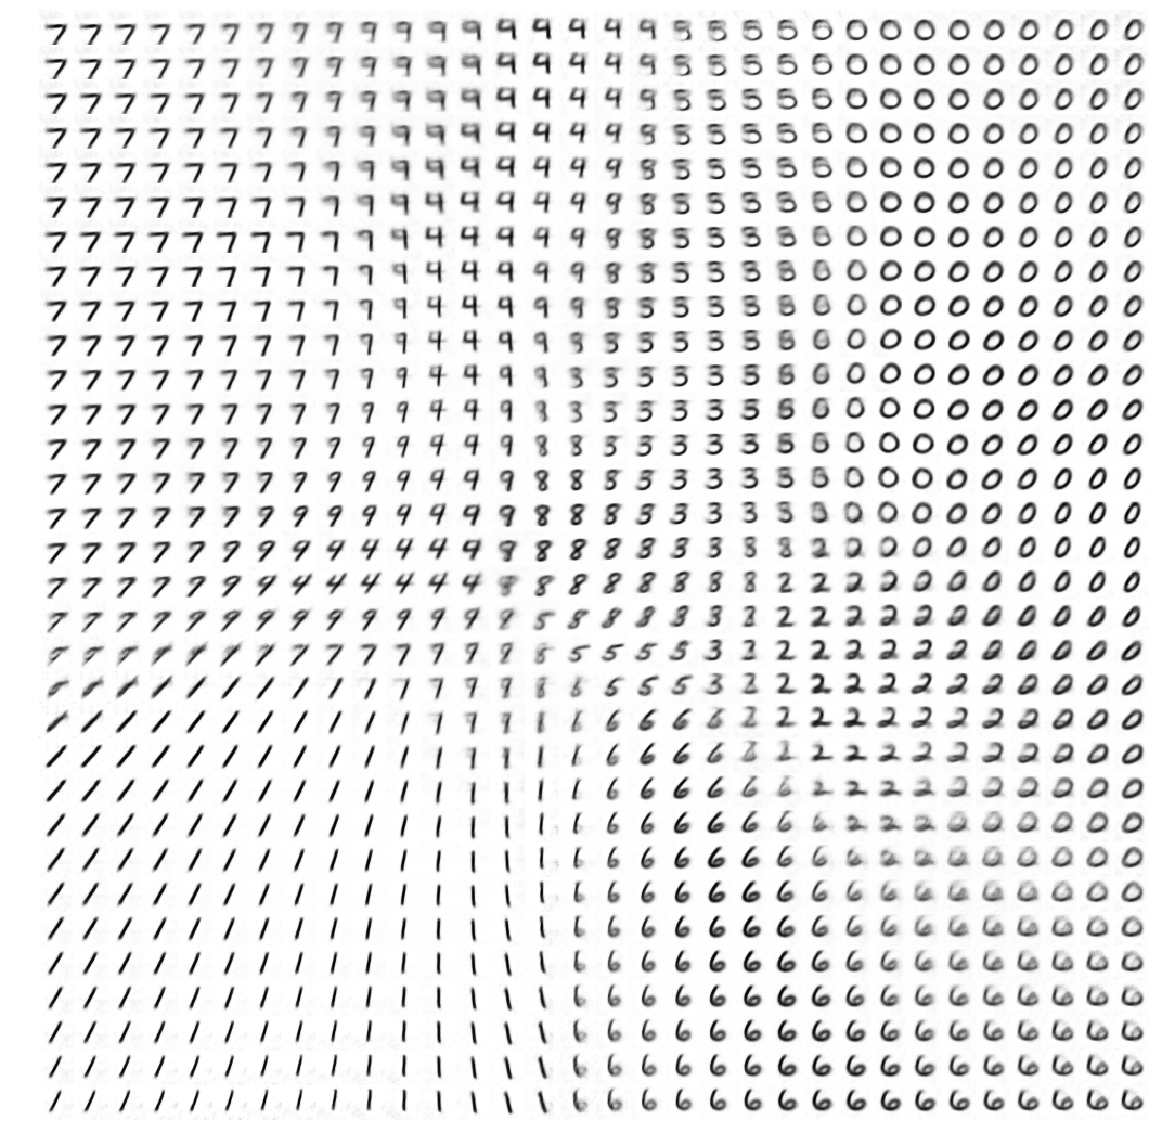

In [19]:
import numpy as np

n_width = 32

nx = ny = 32
x_values = np.linspace(-2.5, 2.5, nx)
y_values = np.linspace(-2.5, 2.5, ny)
canvas = np.empty((n_width * ny, n_width * nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]] * vae.batch_size)
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*n_width:(nx-i)*n_width, j*n_width:(j+1)*n_width] = x_mean[0].reshape(n_width, n_width)

plt.clf()
plt.figure(figsize=(16, 16))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray_r")
plt.axis("off")
plt.tight_layout()
plt.show()

In [3]:
from vae import train, VariationalAutoEncoder
from vae_cnn import ConvolutionalVariationalAutoEncoder

network_architecture = {
    "n_width": 32,
    "n_z": 2,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3
}

vae_2d = VariationalAutoEncoder(network_architecture)
vae_2d.load("tmp/VariationalAutoEncoder.20180612150404337640.step40")

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from tmp/VariationalAutoEncoder.20180612150404337640.step40


In [2]:
network_architecture_50 = {
    "n_width": 32,
    "n_z": 50,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3
}

vae = train(VariationalAutoEncoder, network_architecture, training_epochs=101)

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 Cost: 247.448413823 Time: 7.523
Model has been saved to: tmp/VariationalAutoEncoder.20180612155339521941.step0
Epoch: 0002 Cost: 230.092125626 Time: 15.011
Epoch: 0003 Cost: 220.797880707 Time: 22.427
Epoch: 0004 Cost: 210.121456299 Time: 29.894
Epoch: 0005 Cost: 206.871584600 Time: 37.300
Epoch: 0006 Cost: 204.263977661 Time: 44.721
Epoch: 0007 Cost: 202.056687088 Time: 52.120
Epoch: 0008 Cost: 200.234684423 Time: 59.561
Epoch: 0009 Cost: 198.976055578 Time: 66.982
Epoch: 0010 Cost: 197.873012594 Time: 74.421
Epoch: 0011 Cost: 196.918910980 Time: 81.855
Model has been saved to: tmp/VariationalAutoEncoder.20180612155339521941.step10
Epoch: 0012 Cost: 195.977564926 Time: 89.380
Epoch: 0013 Cost: 195.227415568 Time: 96.822
Epoch: 0014 Cost: 194.564376348 Time: 104.228
Epoch: 0015 Cost: 194.032750956 Time: 111.655
Epoch: 0016 Cost: 193.339694061 Time: 119.058
Epoch: 0017 Cost: 192.718949763 Time: 126.500
Epoch: 0018 Cost: 192.382279078 Time: 133.926
Epoch: 0019 Cost: 192.18392

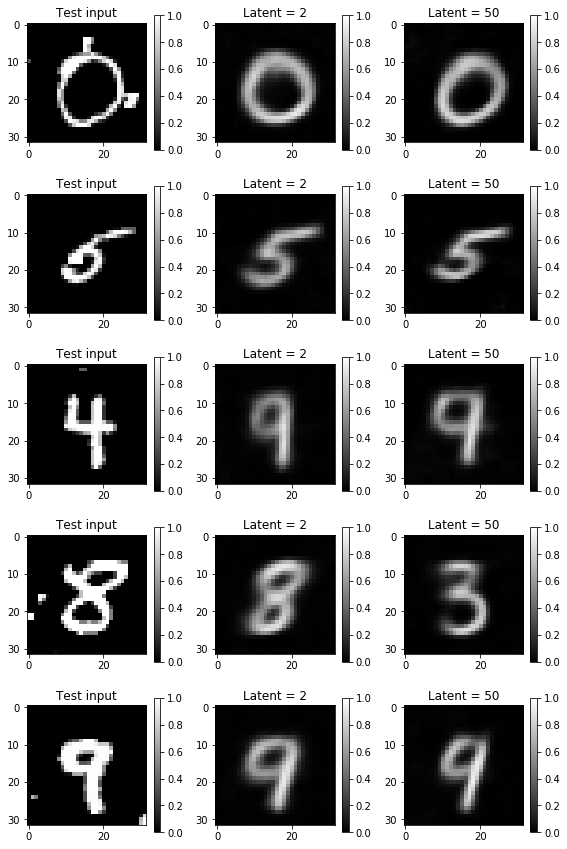

In [15]:
import matplotlib.pyplot as plt
import mnist

x_sample, y_sample = mnist.test_32_flat_labeled(100)
x_sample = x_sample[30:]
y_sample = y_sample[30:]
x_reconstruct_2d = vae_2d.reconstruct(x_sample)
x_reconstruct_50d = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(x_sample[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(x_reconstruct_2d[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.title("Latent = 2")
    plt.colorbar()
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(x_reconstruct_50d[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.title("Latent = 50")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [16]:
from sklearn import svm

x_sample, y_sample = mnist.train_32_flat_labeled(10000)
x_test, y_test = mnist.test_32_flat_labeled(300)

z_mu = vae_2d.transform(x_sample)
clf = svm.SVC()
clf.fit(z_mu, y_sample)
print(clf.score(vae_2d.transform(x_test), y_test))

z_mu = vae.transform(x_sample)
clf = svm.SVC()
clf.fit(z_mu, y_sample)
print(clf.score(vae.transform(x_test), y_test))

0.64
0.6466666666666666


In [1]:
from vae import train, VariationalAutoEncoder

network_architecture_20 = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 2
}

vae = train(VariationalAutoEncoder, network_architecture_20, training_epochs=100)

Epoch: 0001 Cost: 224.240623296 Time: 6.202
Model has been saved to: tmp/VariationalAutoEncoder.20180612173854386484.step0
Epoch: 0002 Cost: 174.659042333 Time: 12.423
Epoch: 0003 Cost: 161.834899038 Time: 18.481
Epoch: 0004 Cost: 156.402069499 Time: 24.563
Epoch: 0005 Cost: 152.649404907 Time: 30.643
Epoch: 0006 Cost: 150.060250397 Time: 36.713
Epoch: 0007 Cost: 148.232697042 Time: 42.792
Epoch: 0008 Cost: 146.882272161 Time: 48.843


KeyboardInterrupt: 

In [1]:
from vae import train, VariationalAutoEncoder

network_architecture_20 = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 2
}

vae = train(VariationalAutoEncoder, network_architecture_20, training_epochs=100)

Epoch: 0001 Cost: 223.777993546 Time: 6.162
Model has been saved to: tmp/VariationalAutoEncoder.20180612174006696037.step0
Epoch: 0002 Cost: 174.878277918 Time: 12.322
Epoch: 0003 Cost: 162.190758845 Time: 18.371


KeyboardInterrupt: 

In [2]:
from vae import train, VariationalAutoEncoder

network_architecture_20 = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 2
}

vae = train(VariationalAutoEncoder, network_architecture_20, training_epochs=100)

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 Cost: 225.779357834 Time: 6.169
Model has been saved to: tmp/VariationalAutoEncoder.20180612174038240417.step0
Epoch: 0002 Cost: 176.473889567 Time: 12.349
Epoch: 0003 Cost: 162.614783936 Time: 18.432
Epoch: 0004 Cost: 157.542392324 Time: 24.490
Epoch: 0005 Cost: 154.158130086 Time: 30.550
Epoch: 0006 Cost: 151.547148717 Time: 36.592
Epoch: 0007 Cost: 149.499819158 Time: 42.649
Epoch: 0008 Cost: 147.823850098 Time: 48.696
Epoch: 0009 Cost: 146.311039836 Time: 54.778
Epoch: 0010 Cost: 145.189874318 Time: 60.842
Epoch: 0011 Cost: 144.314233653 Time: 66.884
Model has been saved to: tmp/VariationalAutoEncoder.20180612174038240417.step10
Epoch: 0012 Cost: 143.526861369 Time: 73.058
Epoch: 0013 Cost: 142.814149628 Time: 79.132
Epoch: 0014 Cost: 142.177021103 Time: 85.187
Epoch: 0015 Cost: 141.442686259 Time: 91.258
Epoch: 0016 Cost: 140.654455821 Time: 97.338
Epoch: 0017 Cost: 140.092156906 Time: 103.402
Epoch: 0018 Cost: 139.588087387 Time: 109.458
Epoch: 0019 Cost: 139.10954864

In [22]:
from sklearn import svm
import mnist
import time

x_sample, y_sample = mnist.train_32_flat_labeled()
x_test, y_test = mnist.test_32_flat_labeled()

t0 = time.time()
z_mu = vae_2d.transform(x_sample)
clf = svm.SVC()
clf.fit(z_mu, y_sample)
print("VAE 2D + SVM", clf.score(vae_2d.transform(x_test), y_test))
print(time.time() - t0)

t0 = time.time()
z_mu = vae.transform(x_sample)
clf = svm.SVC()
clf.fit(z_mu, y_sample)
print("VAE + SVM", clf.score(vae.transform(x_test), y_test))
print(time.time() - t0)

t0 = time.time()
z_mu = vae_conv.transform(x_sample)
clf = svm.SVC()
clf.fit(z_mu, y_sample)
print("VAE Conv + SVM", clf.score(vae_conv.transform(x_test), y_test))
print(time.time() - t0)

VAE 2D + SVM 0.6944
84.1583936214447
VAE + SVM 0.9403
43.446839332580566
VAE Conv + SVM 0.9634
46.61029100418091


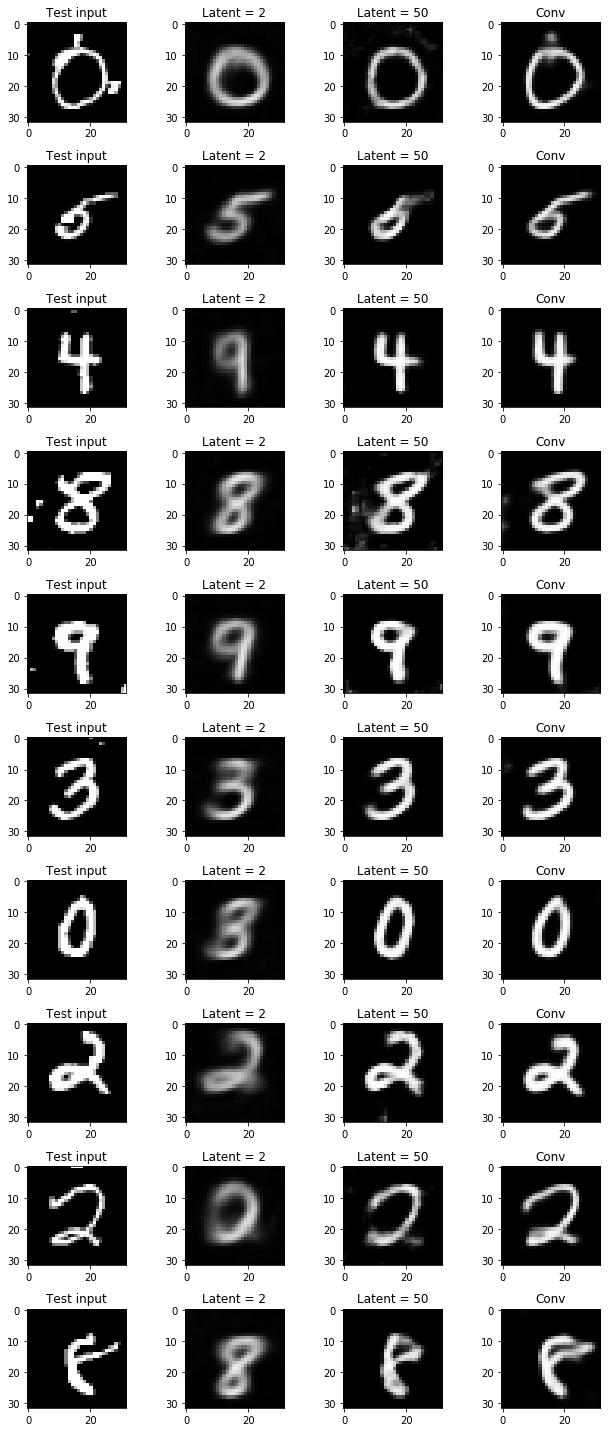

In [19]:
import matplotlib.pyplot as plt
import mnist

x_sample, y_sample = mnist.test_32_flat_labeled(100)
x_sample = x_sample[30:]
y_sample = y_sample[30:]
x_reconstruct_2d = vae_2d.reconstruct(x_sample)
x_reconstruct_50d = vae.reconstruct(x_sample)
x_reconstr_conv = vae_conv.reconstruct(x_sample)

plt.figure(figsize=(9, 20))
for i in range(10):
    plt.subplot(10, 4, 4*i + 1)
    plt.imshow(x_sample[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.subplot(10, 4, 4*i + 2)
    plt.imshow(x_reconstruct_2d[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.title("Latent = 2")
    plt.subplot(10, 4, 4*i + 3)
    plt.imshow(x_reconstruct_50d[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.title("Latent = 50")
    plt.subplot(10, 4, 4*i + 4)
    plt.imshow(x_reconstr_conv[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.title("Conv")
plt.tight_layout()
plt.show()

In [10]:
from vae import train, VariationalAutoEncoder
from vae_cnn import ConvolutionalVariationalAutoEncoder

network_architecture_conv = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3
}

vae_conv = ConvolutionalVariationalAutoEncoder(network_architecture_conv)
vae_conv.load("tmp/ConvolutionalVariationalAutoEncoder.20180611235148068561.step270")

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from tmp/ConvolutionalVariationalAutoEncoder.20180611235148068561.step270


In [25]:
y_pred = clf.predict(vae_conv.transform(x_test))

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 977,    1,    0,    1,    0,    2,    7,    1,    1,    2],
       [   0, 1177,    5,    2,    0,    0,    2,    5,    2,    0],
       [   1,    3, 1001,    2,    3,    3,    1,    6,    9,    2],
       [   0,    0,   14,  977,    1,   12,    3,    3,   15,    5],
       [   1,    3,    3,    0,  887,    0,    4,    6,    1,   22],
       [   2,    1,    1,   16,    0,  849,   12,    0,   10,    3],
       [   4,    3,    0,    3,    3,    5, 1001,    0,    1,    1],
       [   2,    5,    8,    4,    9,    1,    1,  978,    0,   20],
       [   2,    2,    4,   12,    2,    8,    3,    4,  875,   10],
       [   3,    1,    2,    2,   17,    3,    2,   14,    6,  912]])

In [27]:
from vae_conditional import train_cvae

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3,
}

cvae = train_cvae(network_architecture, saving_step=5, training_epochs=200)

ValueError: Tensor("input_layer/concat:0", shape=(?, 10), dtype=float32) must be from the same graph as Tensor("flatten/Reshape:0", shape=(?, 1024), dtype=float32).